In [5]:
%matplotlib notebook 

In [53]:
from NBC_fonctions import *
import os

from CPclass import phone as CP



import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import signal,fft
from scipy.signal import find_peaks
import sys
import os
from scipy import stats
from pickle import load
import joblib

In [54]:
def findMiddle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return int(middle - .5)
    else:
        return int(middle)
def calc_rms(data):
    return np.sqrt(np.mean(data ** 2))


def calc_mean_abs_deviation(data):
    return stats.median_abs_deviation(data)


def calc_data_entropy(data):
    value, counts = np.unique(data, return_counts=True)
    return stats.entropy(counts)

def calc_index_max(data):
    data = list(data)
    return data.index(min(data))

def calc_index_min(data):
    data = list(data)
    return data.index(max(data))

def calc_energy(data):
    squares = data ** 2
    return squares.sum()

def calc_sma(data):
    absolute = list(map(abs, data))
    return sum(absolute)


def _dominant_frequency(signal_x, sampling_rate=100):

    signal_x = signal_x-np.mean(signal_x)
    dim = signal_x.shape
    
    #valerie from matlab
    nfft=1024
    freq_hat = np.fft.fftfreq(nfft) * sampling_rate
    
    #freq are freq from 0 to 50 hz
    freq = freq_hat[0:nfft // 2]
    
    #valerie from matlab
    fmin=0.5
    fmax=4 
    lowind=np.where(freq>fmin)[0][0]
    upind=np.max(np.where(freq<fmax))

    # fourier transform
    #valerie add hamming
    # nfft is used for padding
    haming= np.hamming(dim[0])
    sp_hat = np.fft.fft(signal_x*haming, nfft)
    furval = sp_hat[0:nfft // 2] * np.conjugate(sp_hat[0:nfft // 2])
    furval=furval/sum(furval)

    #from the internet
    # cutoff is 12 
    cutoff=12.0
    idx1 = freq <= cutoff
    idx_cutoff = np.argwhere(idx1)
    #all freq less than cutoff
    freq = freq[idx_cutoff]
    #keep values less than cutoff
    sp = furval[idx_cutoff]
    #normalise
    sp_norm = sp / sum(sp)
    furval=furval/sum(furval)

    max_freq = freq[sp_norm.argmax()][0] # Feature 1: dominant freq 
    max_freq_val = sp_norm.max().real    #Feature 2: magnitude of dominant freq
    idx2 = (freq > max_freq - 0.5) * (freq < max_freq + 0.5)  
    idx_freq_range = np.where(idx2)[0]
    dom_freq_ratio = sp_norm[idx_freq_range].real.sum() #Feature 3: dominant frequency ratio

    # Calculate Feature 4: spectral flatness 
    spectral_flatness = 10.0*np.log10(stats.mstats.gmean(sp_norm)/np.mean(sp_norm))

    # Calculate Feature 5: Estimate spectral entropy
    spectral_entropy_estimate = 0
    for isess in range(len(sp_norm)):
        if sp_norm[isess] != 0:
            logps = np.log2(sp_norm[isess])
        else:
            logps = 0
        spectral_entropy_estimate = spectral_entropy_estimate - logps * sp_norm[isess]

    spectral_entropy_estimate = spectral_entropy_estimate / np.log2(len(sp_norm))

    # from valerie matlab
    Ns=10
    domfreq=np.zeros((1,3))
    fourcoef=np.zeros((1,3), dtype=complex)
    fourcoef[0,0]=(furval[lowind+np.argmax(np.abs(furval[lowind:upind]))])
    ind=lowind+np.argmax(np.abs(furval[lowind:upind]))
    idx=np.where(furval==fourcoef[0,0])[0][0]
    domfreq[0,0]=freq[idx] # it is equal to the maximum frequency ==Max_freq 
    furval[np.maximum(1,ind-Ns):(ind+Ns)]=0 
    fourcoef[0,1]=(furval[lowind+np.argmax(np.abs(furval[lowind:upind]))])
    ind=lowind+np.argmax(np.abs(furval[lowind:upind]))
    idx=np.where(furval==fourcoef[0,1])[0][0]
    domfreq[0,1]=freq[idx] #second dominant freq
    furval[np.maximum(1,ind-Ns):(ind+Ns)]=0
    fourcoef[0,2]=(furval[lowind+np.argmax(np.abs(furval[lowind:upind]))])
    ind=lowind+np.argmax(np.abs(furval[lowind:upind]))
    idx=np.where(furval==fourcoef[0,2])[0][0]
    domfreq[0,2]=freq[idx] #Third dominant freq

    return max_freq,max_freq_val,dom_freq_ratio,spectral_flatness[0].real,spectral_entropy_estimate[0].real,domfreq

6 fichiers importés avec succès


<IPython.core.display.Javascript object>


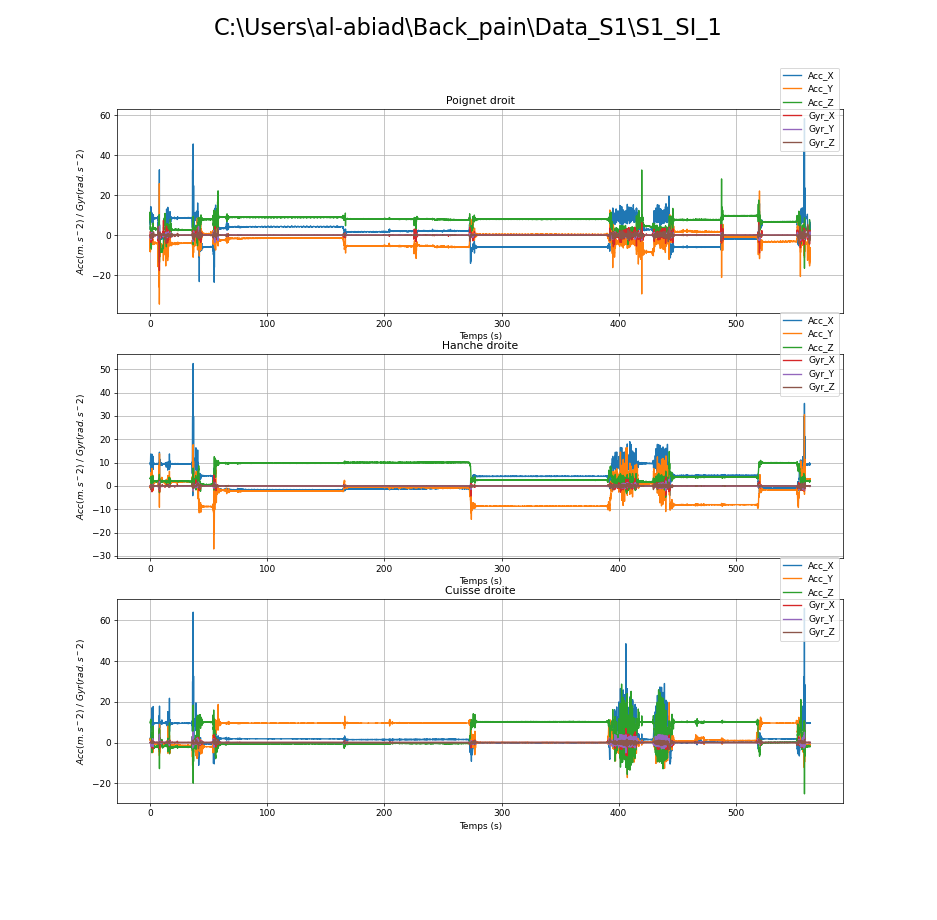

Signaux de 3 capteurs affichés avec succès


In [67]:
dossier=os.getcwd()+'\\Data_S1\\S1_SI_1'


exceptions=["S1_SI_1_gaitupraw.BIN","S1_SI_1_phone.csv"]

DATA,NAME,FREQ,ETIQUETTE,ind_a_tracer=importation(dossier,exceptions)
plot_signaux(DATA,ind_a_tracer,ETIQUETTE,dossier) 

In [68]:
# index 1 is the hand
print(DATA[1].head())
print("the Acc columns of xsens data are {0}".format(DATA[0].columns[0:3]))
print("the Gyr columns of xsens data are {0}".format(DATA[0].columns[3:]))

print(ETIQUETTE)
print(ind_a_tracer)

             Acc_X     Acc_Y      Acc_Z     Gyr_X     Gyr_Y     Gyr_Z
0.000000  2.991943 -5.445557   7.635498  1.516295 -1.224572  0.174416
0.016667  3.492508 -4.067745   8.271675  1.493973 -1.133240  0.158851
0.033334  3.977051 -3.065186   9.543457  1.380319 -1.027257  0.032502
0.050001  4.844627 -1.925812  11.578617  1.281316 -0.849061 -0.214125
0.066669  5.126953 -0.955811  10.931396  0.822729 -0.795606 -0.320898
the Acc columns of xsens data are Index(['Acc_X', 'Acc_Y', 'Acc_Z'], dtype='object')
the Gyr columns of xsens data are Index(['Gyr_X', 'Gyr_Y', 'Gyr_Z'], dtype='object')
['Poignet droit', 'Hanche droite', 'Cuisse droite']
[1, 3, 5]


### Interpolate to 100 Hz to use with smartstep

In [69]:
df=DATA[1].copy()
time=DATA[1].index.values

fs=100
t_t=np.linspace(0, time[-1], num=np.int(time[-1]*fs), endpoint=True,dtype=np.float32)
t_t

df=df.reindex(df.index.union(t_t))
df=df.interpolate(method='linear', limit_direction='both', axis=0)
df=df[df.index.isin(pd.Index(t_t))]

df.index=np.around(df.index.astype('float64'),decimals=4)

In [70]:
Gyro=df[df.columns[3:]]
Acc=df[df.columns[0:3]]
Gyro

Gyr_X     Gyr_Y     Gyr_Z
0.00    1.516295 -1.224572  0.174416
0.01    1.505134 -1.178906  0.166633
0.02    1.456088 -1.097913  0.116734
0.03    1.418204 -1.062585  0.074618
0.04    1.347318 -0.967858 -0.049707
...          ...       ...       ...
563.46  1.202446  1.345471 -1.822878
563.47  1.438209  1.192715 -1.686603
563.48  1.577074  1.124427 -1.593173
563.49  1.958861  0.922119 -1.298715
563.50  2.201784  0.788101 -1.097688

[56350 rows x 3 columns]

In [71]:
Xsens_data=CP(acc=Acc,gyro=Gyro,app="manual_entry")

<IPython.core.display.Javascript object>


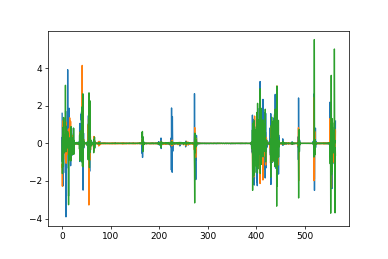

In [72]:
Xsens_data.filter_data(acc=Xsens_data.acc_interp,gyro=Xsens_data.gyro_interp,N=10,fc=2,fs=100)

acc_filtered=Xsens_data.acc_filtered
gyro_filtered=Xsens_data.gyro_filtered

plt.figure()
plt.plot(gyro_filtered)

<IPython.core.display.Javascript object>


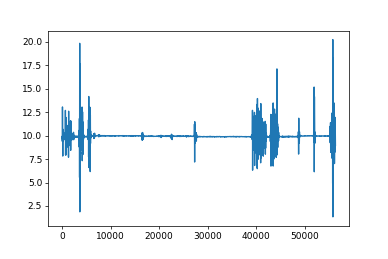

<IPython.core.display.Javascript object>


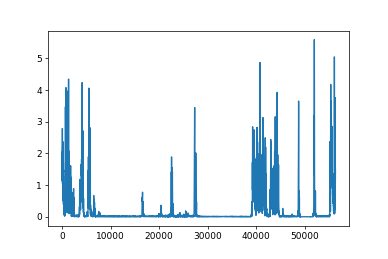

In [73]:
Xsens_data.calculate_norm_accandgyro(gyro=gyro_filtered,acc=acc_filtered)

plt.figure()
plt.plot(Xsens_data.acc_magnitude)

plt.figure()
plt.plot(Xsens_data.gyro_magnitude)

acc_mag_filtered=Xsens_data.acc_magnitude
gyro_mag_filtered=Xsens_data.gyro_magnitude

<IPython.core.display.Javascript object>


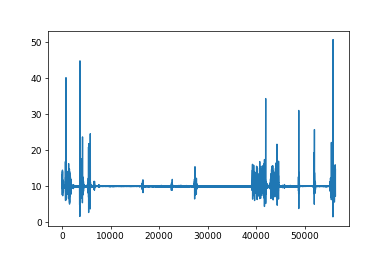

<IPython.core.display.Javascript object>


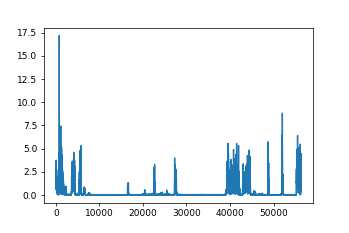

In [74]:
Xsens_data.calculate_norm_accandgyro(gyro=Xsens_data.gyro_interp,acc=Xsens_data.acc_interp)

plt.figure()
plt.plot(Xsens_data.acc_magnitude)

plt.figure()
plt.plot(Xsens_data.gyro_magnitude)

acc_mag_unfiltered=Xsens_data.acc_magnitude

gyro_mag_unfiltered=Xsens_data.gyro_magnitude

In [75]:
window_size80= 80
window_size5= 5
window_size30= 30
window_size20= 20
window_size50= 50
window_size60= 60
window_size70= 70
window_slide_step=1
window_freq=128

acc_features=pd.DataFrame()
gyro_features=pd.DataFrame()

s=0


signals=[acc_mag_filtered,gyro_mag_filtered]

signals_unfiltered=[acc_mag_unfiltered,gyro_mag_unfiltered]

########Feature Calculation#######
for sig in signals:
    print("calculating both signals")
    acc_minindex_win30=[]
    acc_skew_win5=[]
    acc_median_win80=[]
    acc_valleyprom_win80=[]
    acc_peakprom_win80=[]
    acc_peakprom_win50=[]
    acc_domfreq1=[]
    acc_kurt_win30=[]

    gyro_maxindex_win60=[]
    gyro_skew_win70=[]
    gyro_skew_win30=[]
    gyro_maxfreqvalue=[]
    gyro_SMA_win80=[]
    gyro_var_win20=[]
    gyro_maxvalue_win70=[]
    gyro_valleyprom_win80=[]


    for i in range(window_freq//2,len(sig)-window_freq//2,window_slide_step):

        mag30=sig[i-(window_size30//2):i+1+(window_size30//2)]
        mag30_nomean=mag30-np.mean(mag30)

        mag5=sig[i-(window_size5//2):i+1+(window_size5//2)]


        mag80=sig[i-(window_size80//2):i+1+(window_size80//2)]
        mag80_nomean=mag80-np.mean(mag80)

        mag50=sig[i-(window_size50//2):i+1+(window_size50//2)]
        mag50_nomean=mag50-np.mean(mag50)

        mag60=sig[i-(window_size60//2):i+1+(window_size60//2)]


        mag70=sig[i-(window_size70//2):i+1+(window_size70//2)]


        mag20=sig[i-(window_size20//2):i+1+(window_size20//2)]
        mag20_nomean=mag20-np.mean(mag20)


        mag_freq=signals_unfiltered[s][i-window_freq//2:i+(window_freq//2)+1]


        #===============================================

        if s==0:
            print("calculating acceleration")
            
            acc_minindex_win30.append(calc_index_min(mag30_nomean))
            
            acc_skew_win5.append(stats.skew(mag5))
            acc_median_win80.append(np.median(mag80))
            acc_kurt_win30.append(stats.kurtosis(mag30))

            peak_index,peak_properties= find_peaks(mag80_nomean,prominence=(None,None)) 
            if peak_index.size>0:
                ind_mid=findMiddle(peak_index)
                acc_peakprom_win80.append(peak_properties["prominences"][ind_mid])
            else:
                acc_peakprom_win80.append(50)

            peak_index,peak_properties= find_peaks(mag50_nomean,prominence=(None,None)) 
            if peak_index.size>0:
                ind_mid=findMiddle(peak_index)
                acc_peakprom_win50.append(peak_properties["prominences"][ind_mid])
            else:
                acc_peakprom_win50.append(50)

            valley_index,valley_properties= find_peaks(-mag80_nomean,prominence=(None,None))
            if valley_index.size>0:
                ind_mid=findMiddle(valley_index)
                acc_valleyprom_win80.append(valley_properties["prominences"][ind_mid])
            else:
                acc_valleyprom_win80.append(50)

            _,_,_,_,_,domfreq=_dominant_frequency(mag_freq)


            acc_domfreq1.append(domfreq[0,0])



        if s==1:
            print("gyro")
            gyro_skew_win70.append(stats.skew(mag70))
            gyro_skew_win30.append(stats.skew(mag30))
            gyro_maxindex_win60.append(calc_index_max(mag60))
            gyro_SMA_win80.append(calc_sma(mag80_nomean))
            gyro_var_win20.append(np.var(mag20_nomean))
            gyro_maxvalue_win70.append(np.amax(mag70))
            valley_index,valley_properties= find_peaks(-mag80_nomean,prominence=(None,None))

            if valley_index.size>0:
                ind_mid=findMiddle(valley_index)
                gyro_valleyprom_win80.append(valley_properties["prominences"][ind_mid])
            else:
                gyro_valleyprom_win80.append(50)

            _,max_fr_val,_,_,_,_=_dominant_frequency(mag_freq)

            gyro_maxfreqvalue.append(max_fr_val)

    if s==0: 
        print("acceleration features")
        acc_features['acc_indMin_win30']=acc_minindex_win30
        acc_features['acc_skew_win5']=acc_skew_win5
        acc_features['acc_Median_win80']=acc_median_win80
        acc_features['acc_peak_prominences80']=acc_peakprom_win80
        acc_features['acc_peak_prominences50']=acc_peakprom_win50
        acc_features['acc_valley_prominences80']=acc_valleyprom_win80
        acc_features['acc_domfreq1']=acc_domfreq1
        acc_features['acc_kurt_win30']=acc_kurt_win30
        acc_features=acc_features

    if s==1:
        print("gyroscope features")
        gyro_features['gyro_skew_win70']=gyro_skew_win70
        gyro_features['gyro_skew_win30']=gyro_skew_win30
        gyro_features['gyro_indMax_win60']=gyro_maxindex_win60
        gyro_features['gyro_SMA_win80']=gyro_SMA_win80
        gyro_features['gyro_var_win20']=gyro_var_win20
        gyro_features['gyro_Max_win70']=gyro_maxvalue_win70
        gyro_features['gyro_valley_prominences80']=gyro_valleyprom_win80
        gyro_features['gyro_max_freq_val']=gyro_maxfreqvalue
        gyro_features=gyro_features
    s=s+1

calculating both signals
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


In [76]:
feat_gyro=['gyro_indMax_win60',
 'gyro_skew_win70',
 'gyro_max_freq_val',
 'gyro_SMA_win80',
 'gyro_skew_win30',
 'gyro_var_win20',
 'gyro_Max_win70',
 'gyro_valley_prominences80']

feat_acc=['acc_indMin_win30', 'acc_skew_win5', 'acc_Median_win80',
        'acc_kurt_win30',
       'acc_valley_prominences80', 'acc_peak_prominences80',
       'acc_peak_prominences50',  'acc_domfreq1']

In [77]:
joblib_file = "d:\\Users\\al-abiad\\Desktop\\experiments\\treadmill\\machine_learning_features\\joblib_Model_accv3.pkl" 
Model_acc = joblib.load(joblib_file)
joblib_file = "d:\\Users\\al-abiad\\Desktop\\experiments\\treadmill\\machine_learning_features\\joblib_Model_gyrov3.pkl" 
Model_gyro = joblib.load(joblib_file)
steps_in_window=[]
maxprobacc=0.5
maxprobgyro=0.5
index=0

In [78]:
stepacc=True
steps_in_window=[]
changethreshacc=0
changethreshgyro=0
maxprobacc=0.5
maxprobgyro=0.5
nostep_distance=0
threshdistance=80
count=0
stepacc=False
stepgyro=False
distance_cond=False
index=0
while index< len(gyro_features):
# for index, window in X_test.iterrows():
    
    featgyro=gyro_features.iloc[index,:][feat_gyro]
    featacc=acc_features.iloc[index,:][feat_acc]
    
    

    y_predprobacc= Model_acc.predict_proba([featacc])

    y_predprobgyro= Model_gyro.predict_proba([featgyro])
    


    
    if (y_predprobgyro[0][1]>maxprobgyro):
        steps_in_window.append(1)
        print("Model is gyro")
        index=index+1
        distance=0
        while distance<80 and index<len(gyro_features):
            print("entered loop")
            featgyro=gyro_features.iloc[index,:][feat_gyro]
            y_predprobgyro= Model_gyro.predict_proba([featgyro])
            
            if(y_predprobgyro[0][1]>maxprobgyro):
                print("step is gyro")
                steps_in_window.append(1)
                distance=0
            else:
                distance=distance+1
                steps_in_window.append(0)
            index=index+1
        
        if index<len(gyro_features):
            print("we entered condition")
            index=index-50
            steps_in_window=steps_in_window[:-50]
            
                
    elif (y_predprobacc[0][1]>maxprobacc):
        steps_in_window.append(1)
        print("Model is acc")
        index=index+1
        distance=0
        print(index)
        while distance<80 and index<len(gyro_features):
            featacc=acc_features.iloc[index,:][feat_acc]
            y_predprobacc= Model_acc.predict_proba([featacc])
            print(index)
            if(y_predprobacc[0][1]>maxprobacc):
                print("step is acc")
                steps_in_window.append(1)
                distance=0
            else:
                distance=distance+1
                steps_in_window.append(0)
            index=index+1
        
        if index<len(gyro_features):
            print("we entered condition")
            index=index-50
            steps_in_window=steps_in_window[:-50]
            

    else:
        steps_in_window.append(0)
        print("irregular or static")
        index=index+1

irregular or static
irregular or static
Model is acc
3
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular o

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
4190
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
Model is acc
5487
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
step is acc
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entere

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
39587
39587
39588
39589
39590
39591
39592
39593
39594
39595
39596
39597
39598
39599
39600
39601
39602
39603
39604
39605
39606
39607
39608
39609
39610
39611
39612
39613
39614
39615
39616
39617
39618
39619
39620
39621
39622
39623
39624
39625
39626
39627
39628
39629
39630
39631
39632
39633
39634
39635
39636
39637
39638
39639
39640
39641
39642
39643
39644
39645
39646
39647
39648
39649
39650
39651
39652
39653
39654
39655
step is acc
39656
39657
39658
39659
39660
39661
39662
39663
39664
39665
39666
39667
39668
39669
39670
39671
39672
39673
39674
39675
39676
39677
39678
39679
39680
39681
39682
39683
39684
39685
39686
39687
39688
39689
39690
39691
39692
39693
39694
3

40667
40668
40669
40670
40671
40672
40673
40674
40675
40676
40677
40678
40679
40680
step is acc
40681
40682
40683
40684
40685
40686
40687
40688
40689
40690
40691
40692
40693
40694
40695
40696
40697
40698
40699
40700
40701
40702
40703
40704
40705
40706
40707
40708
40709
40710
40711
40712
40713
40714
40715
40716
40717
40718
40719
40720
40721
40722
40723
40724
40725
40726
40727
40728
step is acc
40729
40730
40731
40732
40733
40734
40735
40736
40737
40738
40739
40740
40741
40742
40743
40744
40745
40746
40747
40748
40749
40750
40751
40752
40753
40754
40755
40756
40757
40758
40759
40760
40761
40762
40763
40764
40765
40766
40767
40768
40769
40770
40771
40772
40773
40774
40775
40776
40777
40778
40779
40780
40781
40782
40783
40784
40785
40786
40787
40788
40789
40790
40791
40792
40793
40794
40795
40796
40797
40798
40799
40800
40801
40802
40803
40804
40805
40806
40807
40808
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irr

entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular 

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


43855
43856
43857
43858
43859
43860
43861
43862
43863
43864
43865
43866
43867
43868
43869
43870
43871
43872
43873
43874
43875
43876
43877
43878
43879
43880
43881
43882
43883
43884
43885
43886
43887
43888
43889
43890
43891
43892
43893
43894
43895
43896
43897
43898
43899
43900
43901
43902
43903
43904
43905
43906
43907
43908
43909
43910
43911
43912
43913
43914
43915
43916
43917
43918
step is acc
43919
43920
43921
43922
43923
43924
43925
43926
43927
43928
43929
43930
43931
43932
43933
43934
43935
43936
43937
43938
43939
43940
43941
43942
43943
43944
43945
43946
43947
43948
43949
43950
43951
43952
43953
43954
43955
43956
43957
43958
43959
43960
43961
43962
43963
43964
43965
43966
43967
43968
43969
43970
43971
43972
43973
43974
43975
43976
43977
step is acc
43978
43979
43980
43981
43982
43983
43984
43985
43986
43987
43988
43989
43990
43991
43992
43993
43994
43995
43996
43997
43998
43999
44000
44001
44002
44003
44004
44005
44006
44007
44008
44009
44010
44011
44012
44013
44014
44015
44016
4401

44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or stat

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop


55694
55695
55696
55697
55698
55699
55700
55701
55702
55703
55704
55705
55706
55707
55708
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop

In [79]:
def inverse_window_step(windows):
    steps=[]
    ii=0
    for wind in windows:

        if wind==1:
            steps.append(64+ii)
        ii=ii+1
    return steps

In [80]:
steps_smartstep=inverse_window_step(steps_in_window)

<IPython.core.display.Javascript object>


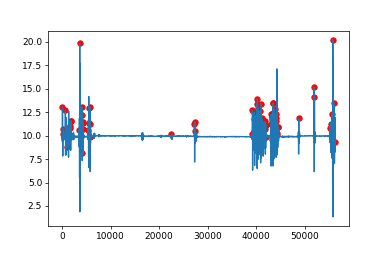

In [81]:
plt.figure()
plt.plot(acc_mag_filtered)
plt.scatter(steps_smartstep,acc_mag_filtered[steps_smartstep],c='r')

<IPython.core.display.Javascript object>


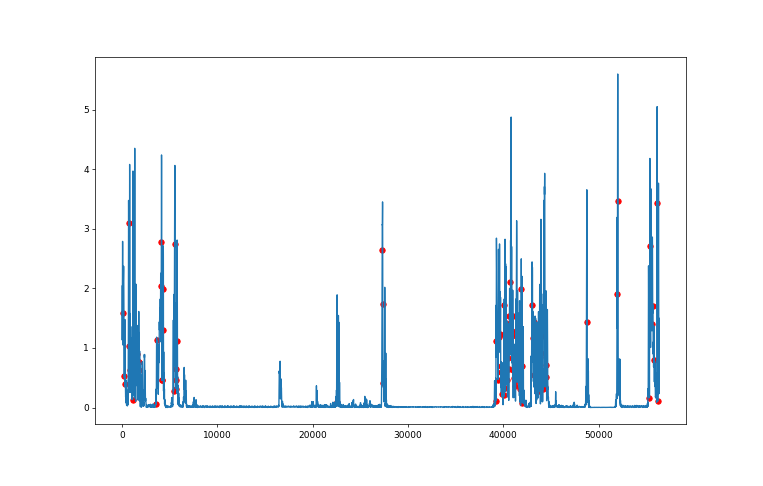

In [82]:
plt.figure()
plt.plot(gyro_mag_filtered)
plt.scatter(steps_smartstep,gyro_mag_filtered[steps_smartstep],c='r')